<a href="https://colab.research.google.com/github/bboszori/data_science_tasks/blob/main/clustering_homework_bboszori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [ ]:
pip install bds_courseware

In [ ]:
pip install yellowbrick

In [ ]:
from bds_courseware import read_drive_dataset
from bds_courseware import print_dataset_description, print_module_datasets
from bds_courseware import HOMEWORK_DATASETS

from itertools import product
from tqdm import tqdm as tqdm

import pandas as pd
import numpy as np
from scipy import stats

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import scipy.cluster.hierarchy as sch

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation

from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score, silhouette_samples

from sklearn.decomposition import PCA

import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram

import os
import random
import warnings
warnings.filterwarnings('ignore')

### Helper functions

In [ ]:
def showWorldMap(clusters):
  # initialize an axis
  fig, ax = plt.subplots(figsize=(14,8))
  # plot map on axis
  countries = gpd.read_file(
      gpd.datasets.get_path("naturalearth_lowres"))
  countries.plot(color="lightgrey",
                                                  ax=ax)

  # plot points
  df.plot(x="Longitude", y="Latitude", kind="scatter",
          c=clusters, colormap="Paired",
          title=f"Earthquakes clusters by {clusters}",
          ax=ax)
  # add grid
  ax.grid(visible=True, alpha=0.5)
  plt.show()

In [ ]:
def plotPCA(clusters):
  df_pca["target"] = df[clusters]

  sns.set(style='ticks')
  sns.relplot(x="x",y="y", data=df_pca, hue="target",palette="Paired").set(title=f'Clusters by {clusters}')

In [ ]:
def plotScatterplot(clusters):
  plt.subplots(figsize=(10,5))

  plt.title(f'Earthquakes by Magnitude  Vs Depth with {clusters} clusters',fontsize=12)
  sns.scatterplot(data=df, x='Richter', y='Focal depth', hue=clusters, palette="Paired")
  plt.ylabel('Earthquake Depth')
  plt.xlabel('Earthquake Magnitude')

### Import data

In [ ]:
print(HOMEWORK_DATASETS.keys())

dict_keys(['suicide_rates', 'car_perfs', 'brain', 'bank', 'air_quality', 'hypothyroid', 'movies', 'bike_sharing_day', 'bike_sharing_hour', 'quake'])


In [ ]:
name = 'quake'
df = read_drive_dataset(*HOMEWORK_DATASETS[name])

In [ ]:
print(df.head(2))
print(df.shape)

   Focal depth  Latitude  Longitude  Richter
0           33    -52.26      28.30      6.7
1           36     45.53     150.93      5.8
(2178, 4)


## Exploratory analysis (there are some specific characteristics of features, which may change the result of the analysis) (10%)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2178 entries, 0 to 2177
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Focal depth  2178 non-null   int64  
 1   Latitude     2178 non-null   float64
 2   Longitude    2178 non-null   float64
 3   Richter      2178 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 68.2 KB


In [ ]:
df.describe()

,Focal depth,Latitude,Longitude,Richter
count,2178.000000,2178.000000,2178.000000,2178.000000
mean,74.359963,7.961997,54.914835,5.977181
std,116.467797,30.545583,118.875581,0.189426
min,0.000000,-66.490000,-179.960000,5.800000
25%,21.000000,-12.432500,-67.782500,5.800000
50%,39.000000,0.210000,122.100000,5.900000
75%,68.000000,36.480000,146.860000,6.100000
max,656.000000,78.150000,180.000000,6.900000


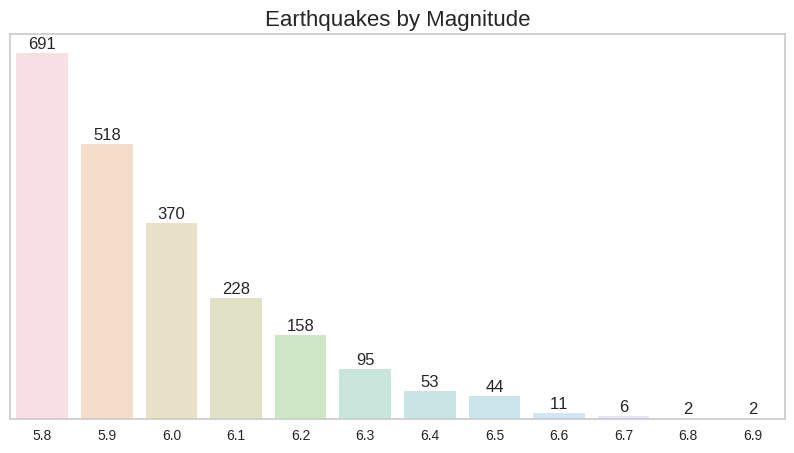

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
plt.title('Earthquakes by Magnitude', fontsize=16)
ax = sns.countplot(x='Richter', data=df, alpha=0.3)
for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+ p.get_width()/2, p.get_height() + 2), ha='center', va='bottom')
plt.ylabel(None), plt.yticks([]), plt.xlabel(None)

plt.show()

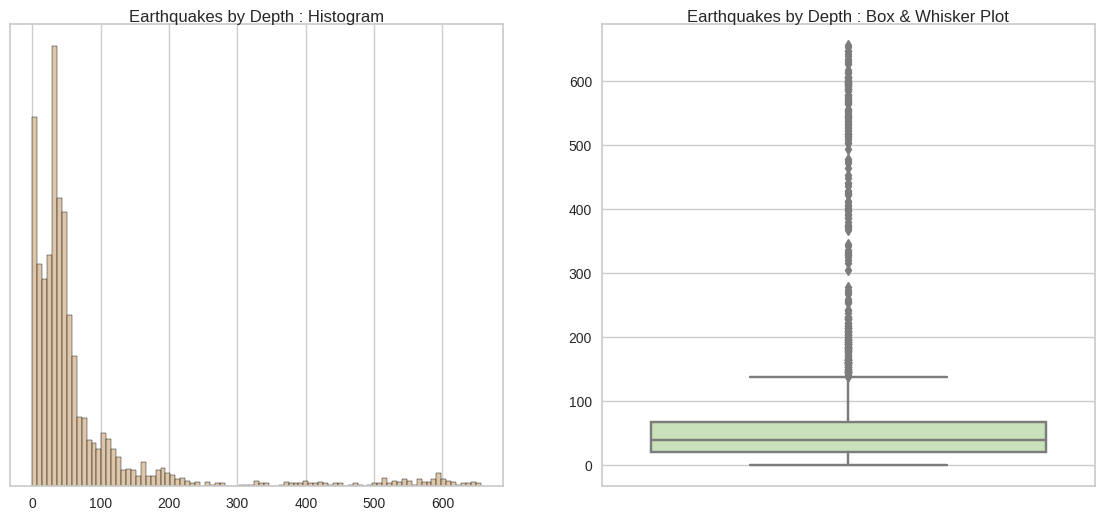

In [ ]:
plt.subplots(figsize=(14,6))

plt.subplot(1, 2,1)
plt.title('Earthquakes by Depth : Histogram', pad=1, fontsize=12)
sns.histplot(df['Focal depth'], color="#D2B48C", kde_kws={'linewidth':1,'color':'b'})
plt.yticks([]), plt.ylabel(None), plt.xlabel(None)

plt.subplot(1,2,2)
plt.title('Earthquakes by Depth : Box & Whisker Plot', pad=1, fontsize=12)
sns.boxplot(df['Focal depth'], color="#c7e9b4", orient='v')
plt.ylabel(None), plt.xlabel(None), plt.xticks([])

plt.ylabel(None), plt.xlabel(None), plt.xticks([])

plt.show()

Text(0.5, 0, 'Earthquake Magnitude')

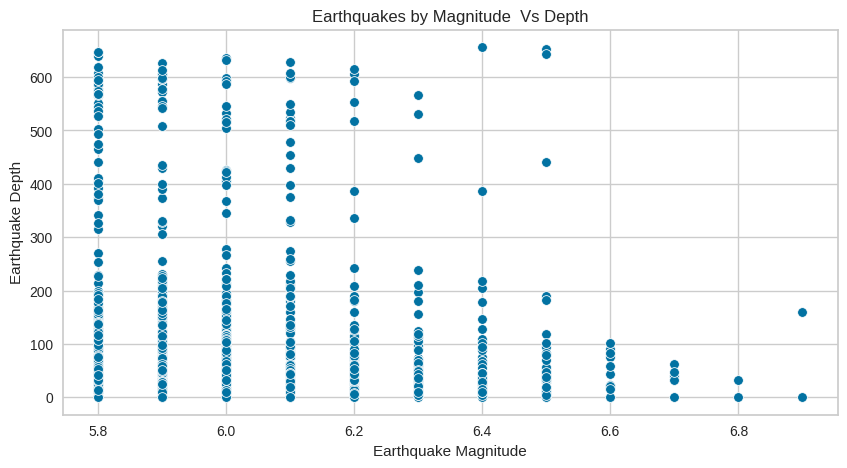

In [ ]:
plt.subplots(figsize=(10,5))

plt.title('Earthquakes by Magnitude  Vs Depth',fontsize=12)
sns.scatterplot(data=df, x='Richter', y='Focal depth')
plt.ylabel('Earthquake Depth')
plt.xlabel('Earthquake Magnitude')

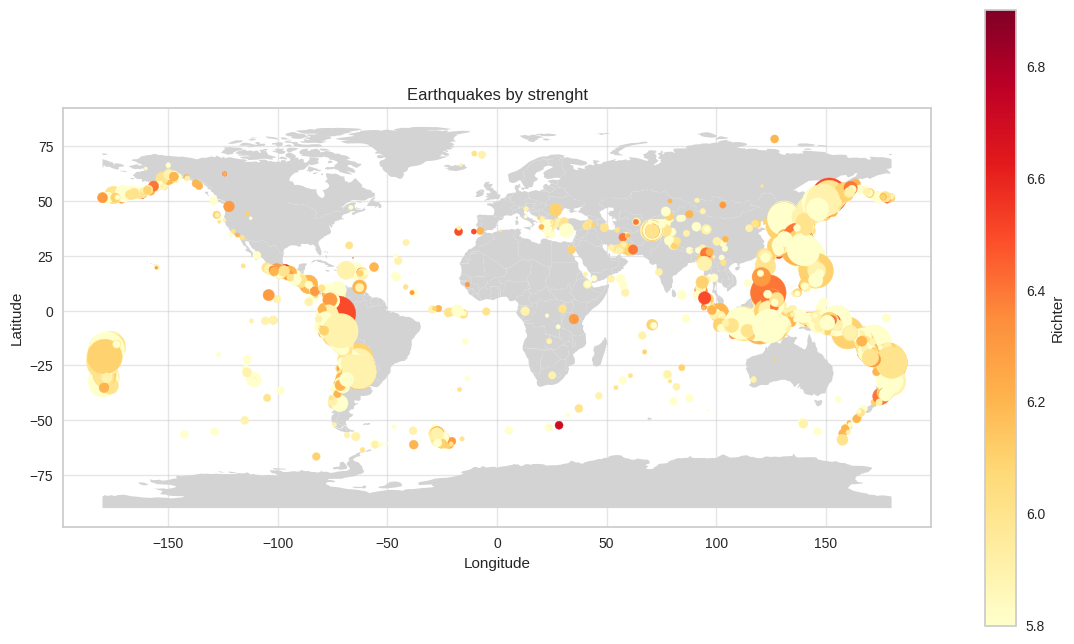

In [ ]:
# initialize an axis
fig, ax = plt.subplots(figsize=(14,8))
# plot map on axis
countries = gpd.read_file(
     gpd.datasets.get_path("naturalearth_lowres"))
countries.plot(color="lightgrey",
                                                 ax=ax)

# plot points
df.plot(x="Longitude", y="Latitude", kind="scatter",
        s="Focal depth", c="Richter", colormap="YlOrRd",
        title=f"Earthquakes by strenght",
        ax=ax)
# add grid
ax.grid(visible=True, alpha=0.5)
plt.show()

In [ ]:
# Using Cartesian coordinates instead of the Longitude/Latitude values
df['x'] = np.cos(np.deg2rad(df['Latitude'])) * np.cos(np.deg2rad(df['Longitude']))
df['y'] = np.cos(np.deg2rad(df['Latitude'])) * np.sin(np.deg2rad(df['Longitude']))
df['z'] = np.sin(np.deg2rad(df['Latitude']))

In [ ]:
mmscaler = MinMaxScaler()
x = pd.DataFrame(mmscaler.fit_transform(df[['Focal depth', 'Richter', 'x','y','z']]), columns=['Focal depth', 'Richter', 'x','y','z'])

In [ ]:
x.describe()

,Focal depth,Richter,x,y,z
count,2178.000000,2178.000000,2178.000000,2178.000000,2178.000000
mean,0.113354,0.161074,0.298232,0.615751,0.546261
std,0.177542,0.172206,0.246969,0.275790,0.250864
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.032012,0.000000,0.090441,0.469996,0.370158
50%,0.059451,0.090909,0.207361,0.689676,0.485660
75%,0.103659,0.272727,0.541491,0.827847,0.797357
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)
df_pca = pd.DataFrame.from_records(data=x_pca[:,:2], columns=["x","y"])

## Build K-Means with 15 clusters (10%)

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=0)
y_kmeans = kmeans.fit_predict(x)
df['kmeans'] = y_kmeans.tolist()

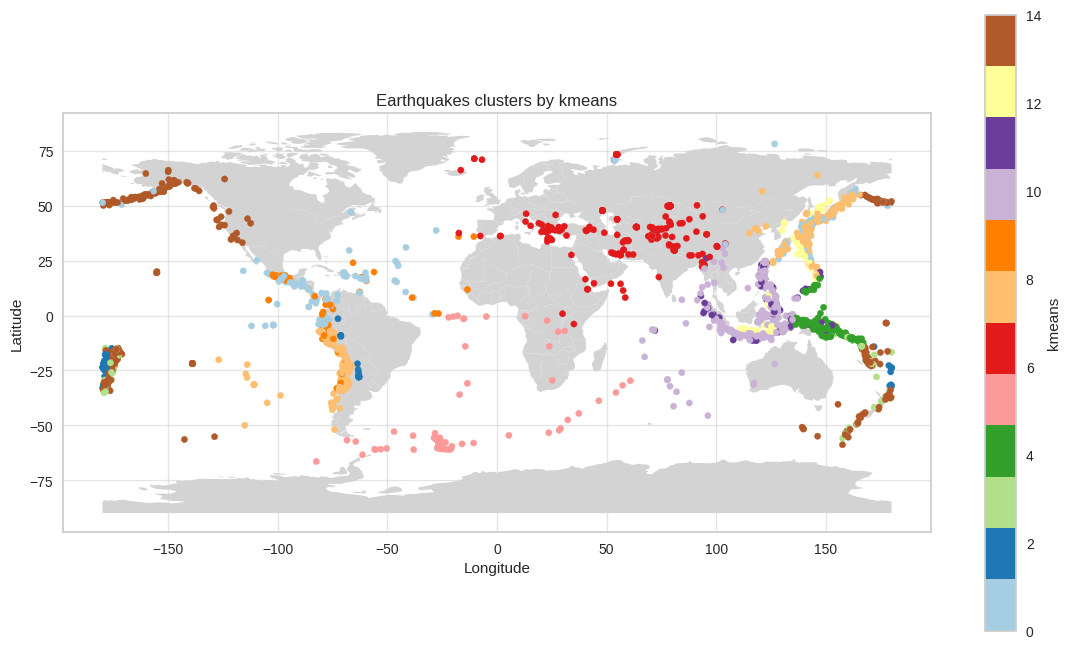

In [ ]:
showWorldMap('kmeans')

## Determine optimal number of clusters for K-Means (10%)

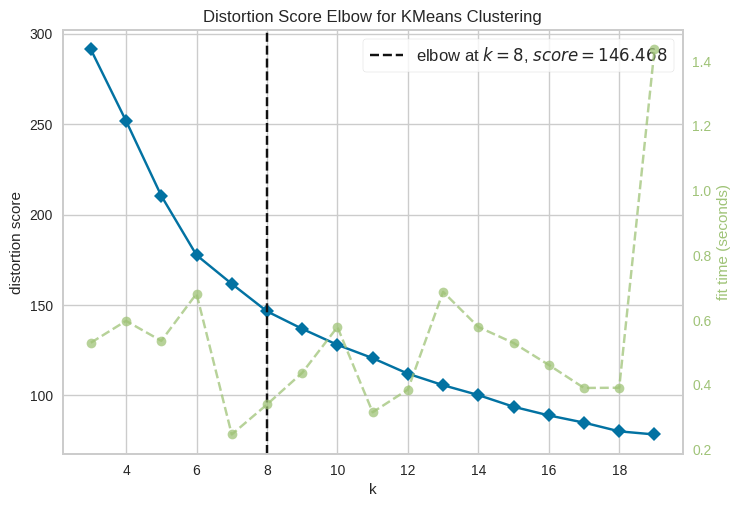

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(3,20))

visualizer.fit(x)
visualizer.show()
plt.show()

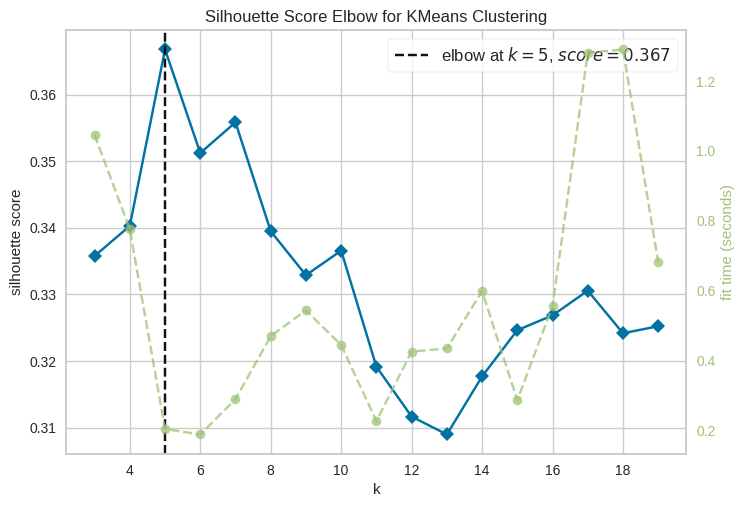

In [ ]:
model = KMeans(random_state=1)
visualizer = KElbowVisualizer(model, k=(3,20), metric='silhouette')

visualizer.fit(x)
visualizer.show()
plt.show()

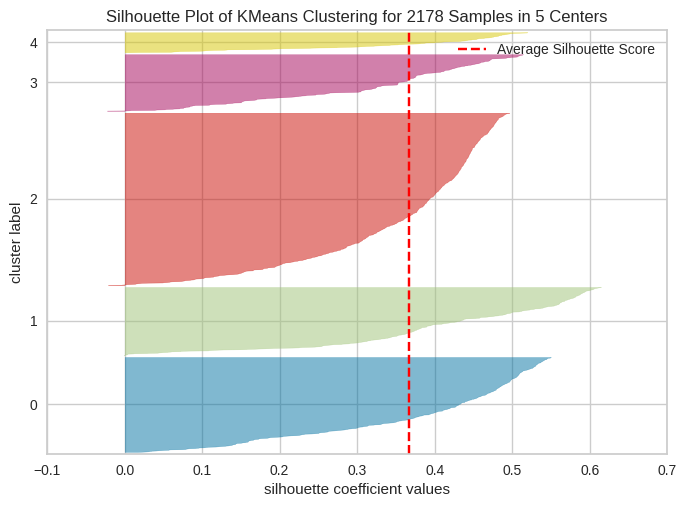

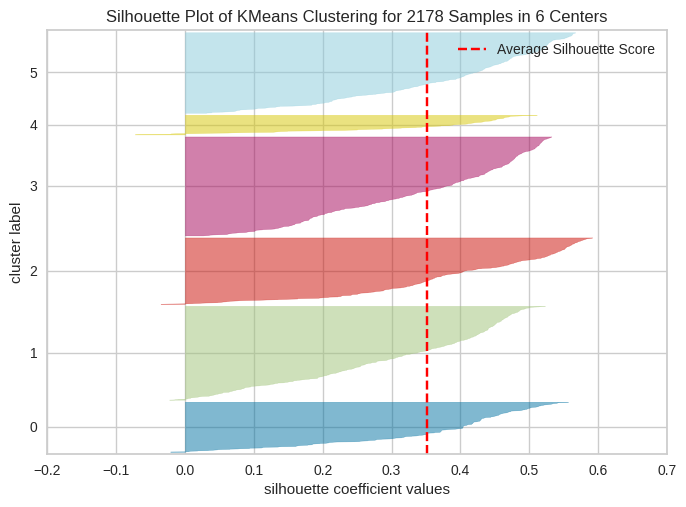

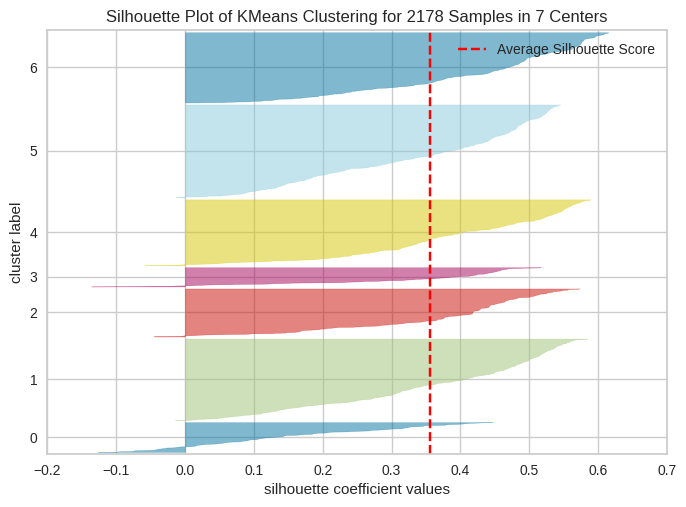

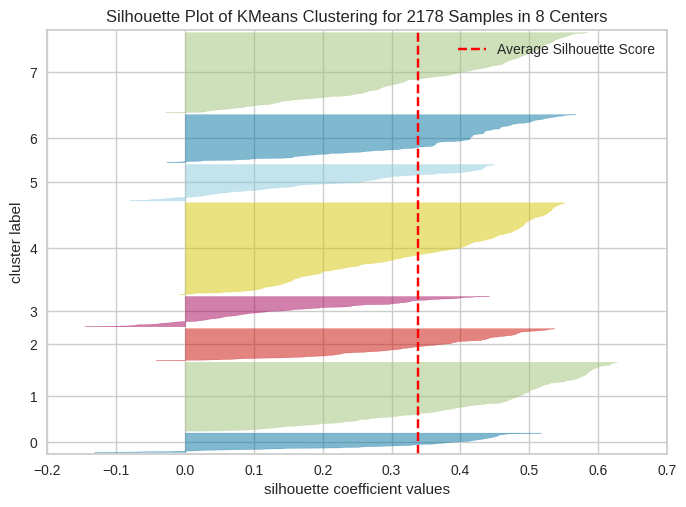

In [ ]:
for i in range(5,9):
  model = KMeans(n_clusters=i, random_state=0)
  visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
  visualizer.fit(x)
  visualizer.show()
  plt.show()

## Create visualization for the obtained clusters (10%)

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=0)
y_kmeans = kmeans.fit_predict(x)
df['kmeans'] = y_kmeans.tolist()

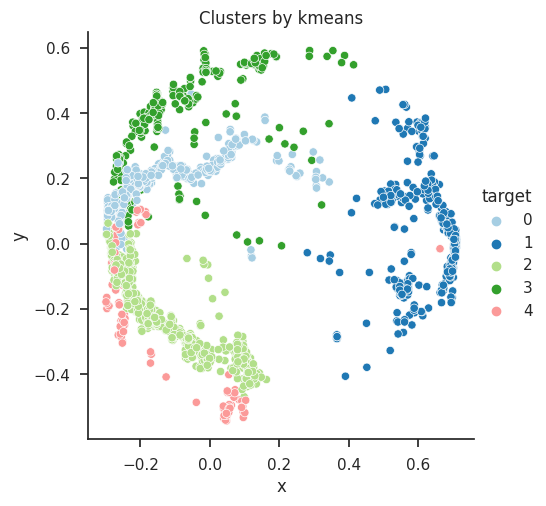

In [ ]:
plotPCA('kmeans')

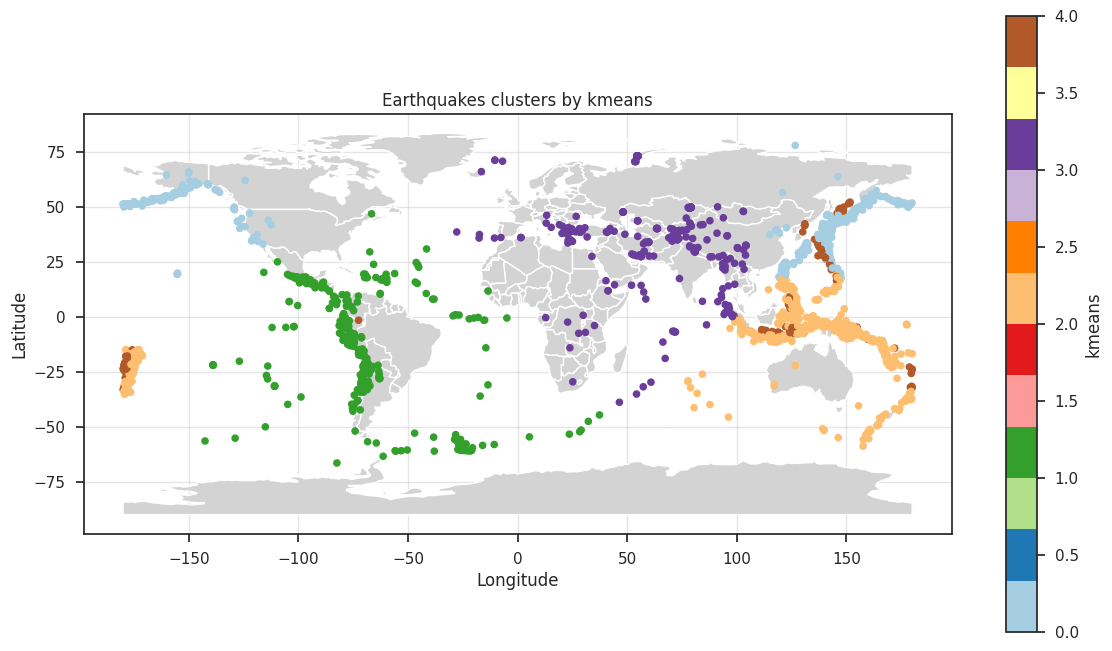

In [ ]:
showWorldMap('kmeans')

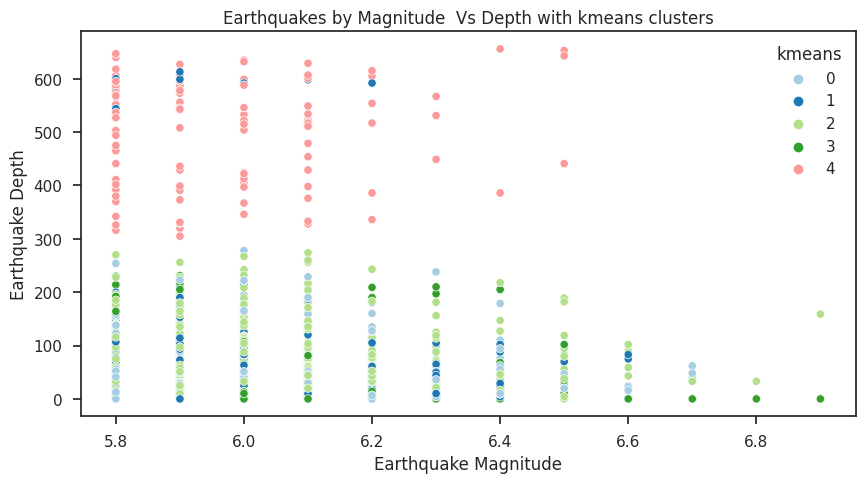

In [ ]:
plotScatterplot('kmeans')

## Try other clustering algorithms; tune their hyperparameters to achieve better results. You should use at least two different algorithms (20%)

### DBSCAN

In [ ]:
eps_values = np.arange(0.001,0.2,0.01)
min_samples = np.arange(1,50,1)

DBSCAN_params = list(product(eps_values, min_samples))

In [ ]:
sil_avg = []
max_value = [0,0,0,0]

for p in DBSCAN_params:
  db = DBSCAN(min_samples = p[1], eps=p[0]).fit(x)
  y = db.labels_
  labels = set(y)

  n_clusters_ = len(labels) - (1 if -1 in labels else 0)

  if n_clusters_>2:
    silhouette_avg = silhouette_score(x, y)
    if silhouette_avg > max_value[3]:
      max_value=(p[0], p[1], n_clusters_, silhouette_avg)
      sil_avg.append(silhouette_avg)

print("epsilon=", max_value[0],
      "\nmin_sample=", max_value[1],
      "\nnumber of clusters=", max_value[2],
      "\naverage silhouette score= %.4f" % max_value[3])

epsilon= 0.19099999999999998 
min_sample= 19 
number of clusters= 3 
average silhouette score= 0.3221


In [ ]:
no_of_clusters = []
sil_score = []
eps = []
minsample = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(x)
    nc = len(np.unique(DBS_clustering.labels_))
    if (nc > 2) & (nc < 10):
      sil_score.append(silhouette_score(x, DBS_clustering.labels_))
      no_of_clusters.append(nc)
      eps.append(p[0])
      minsample.append(p[1])

tmp = pd.DataFrame({'eps':eps, 'minsample': minsample, 'no_of_clusters': no_of_clusters, 'sil_score': sil_score}).sort_values(by=['sil_score'], ascending=False).head(100)

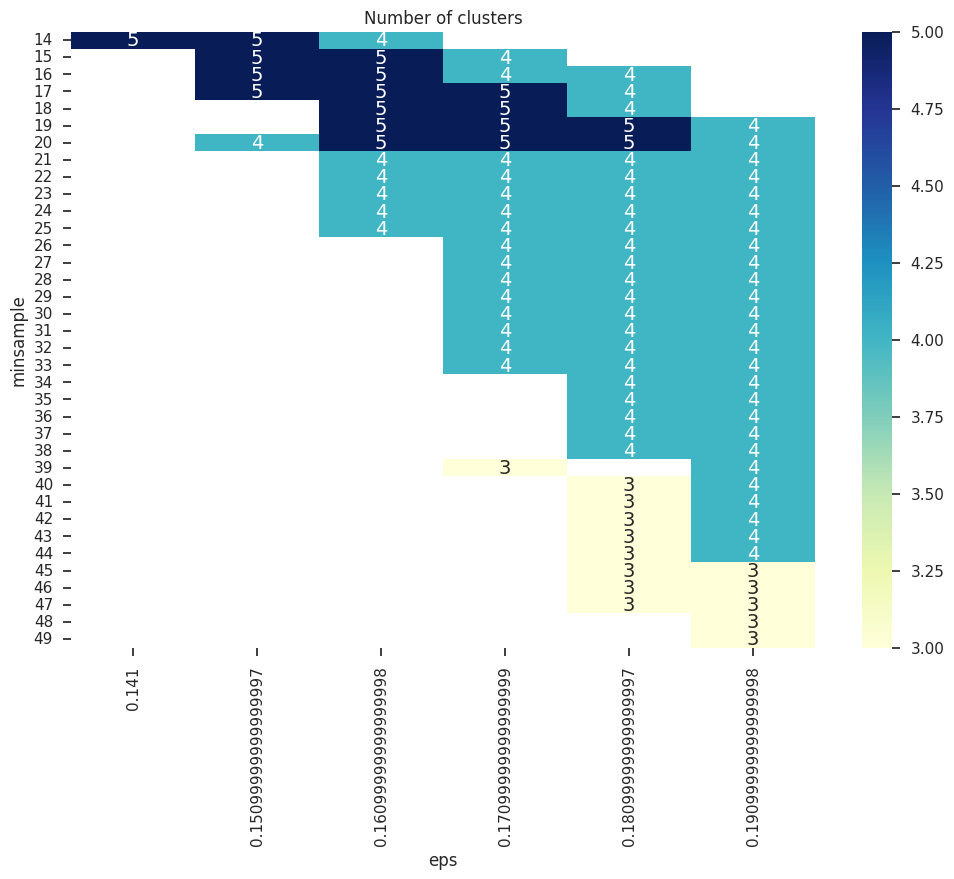

In [ ]:
pivot_1 = pd.pivot_table(tmp, values='no_of_clusters', index='minsample', columns='eps')

fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 14}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

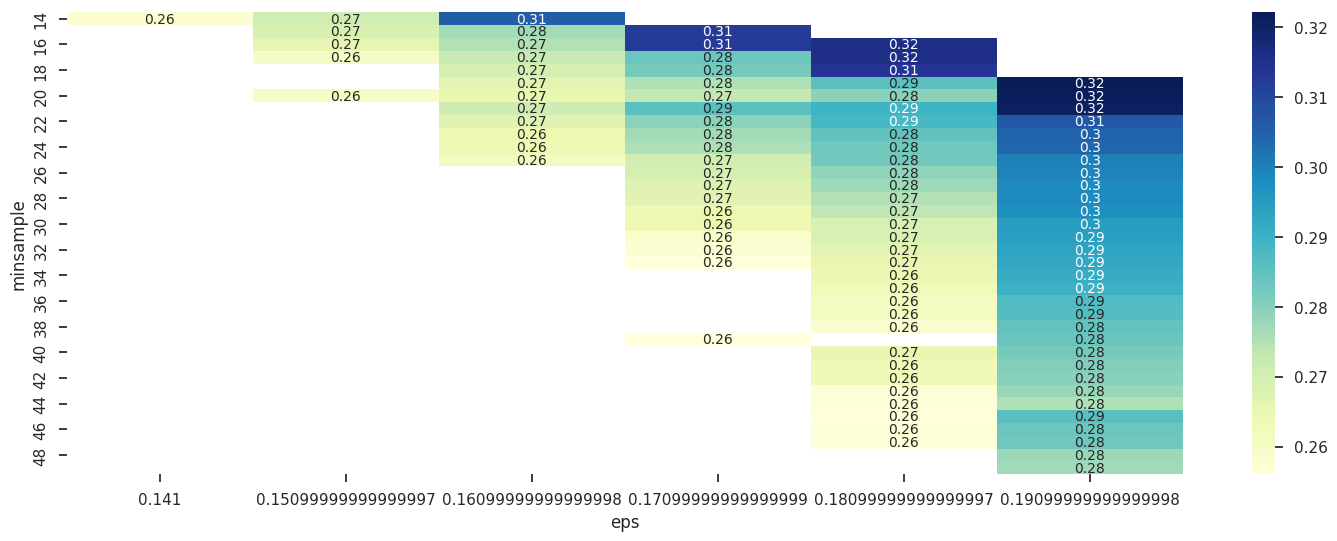

In [ ]:
pivot_1 = pd.pivot_table(tmp, values='sil_score', index='minsample', columns='eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

In [ ]:
dbscan = DBSCAN(eps=0.19099999999999998, min_samples=19)
y_db = dbscan.fit_predict(x)
df['DBSCAN'] = y_db.tolist()
df['DBSCAN'] = df['DBSCAN'].replace(-1, 3)

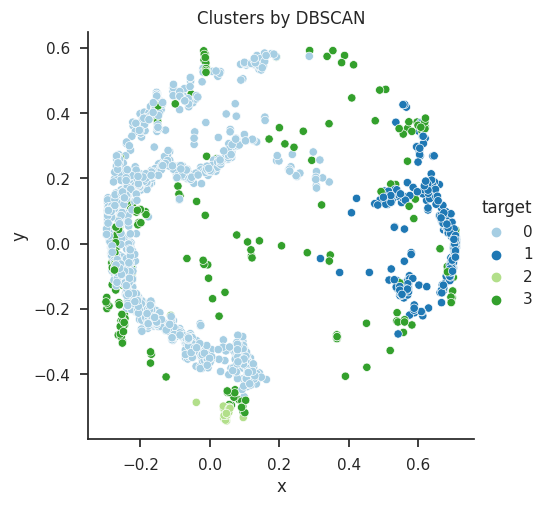

In [ ]:
plotPCA('DBSCAN')

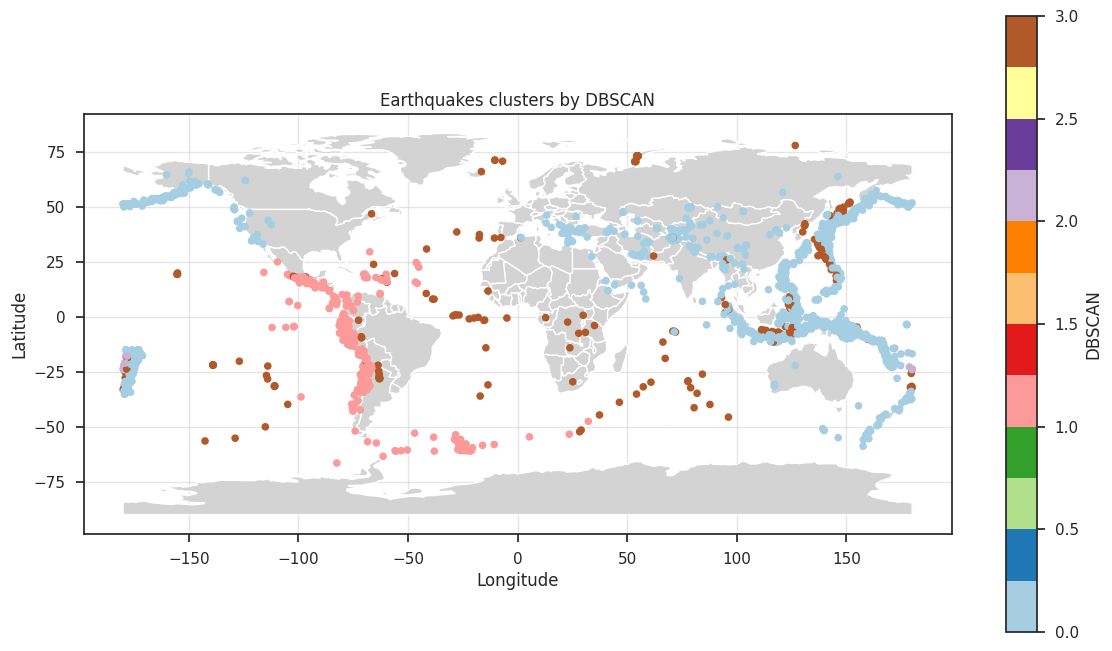

In [ ]:
showWorldMap('DBSCAN')

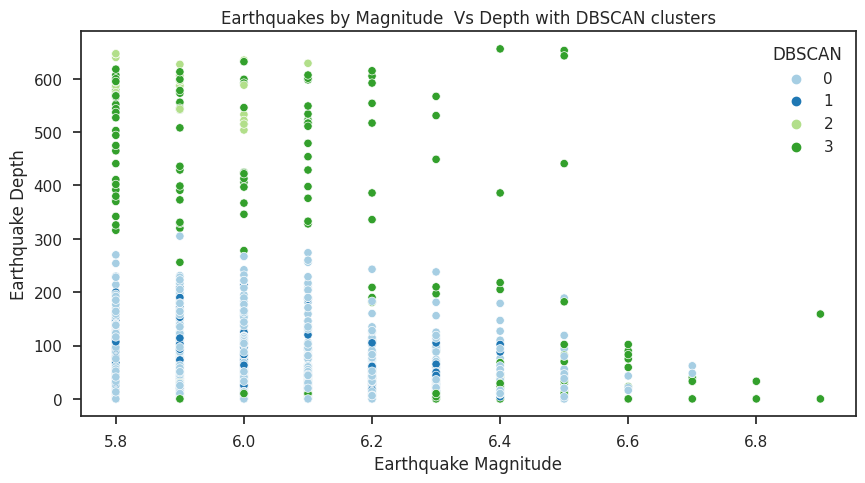

In [ ]:
plotScatterplot('DBSCAN')

### Hierarchical clustering

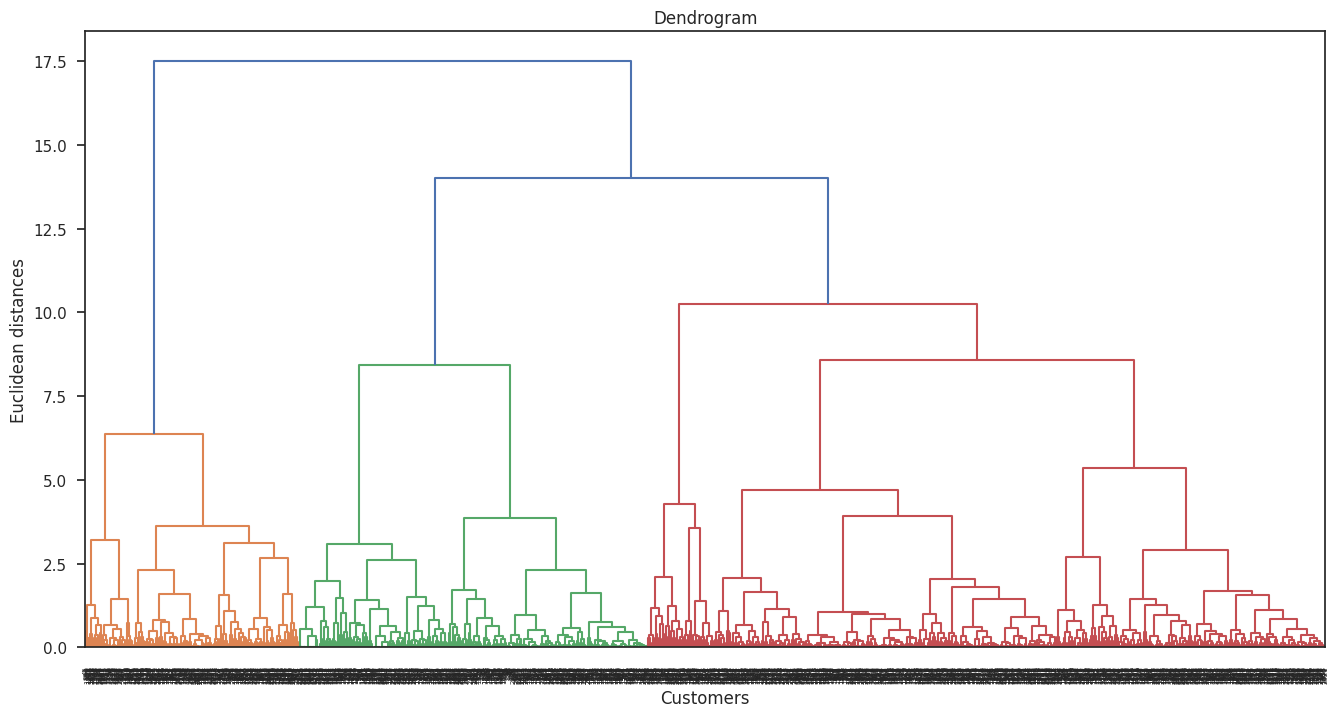

In [ ]:
plt.figure(1, figsize = (16 ,8))
dendrogram = sch.dendrogram(sch.linkage(x, method  = "ward"))

plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()

In [ ]:
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage ='average')
y_hc = hc.fit_predict(df)
df['hierarchical'] = y_hc.tolist()

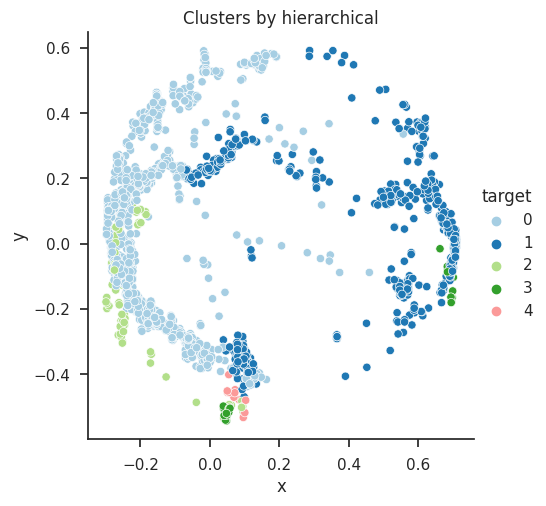

In [ ]:
plotPCA('hierarchical')

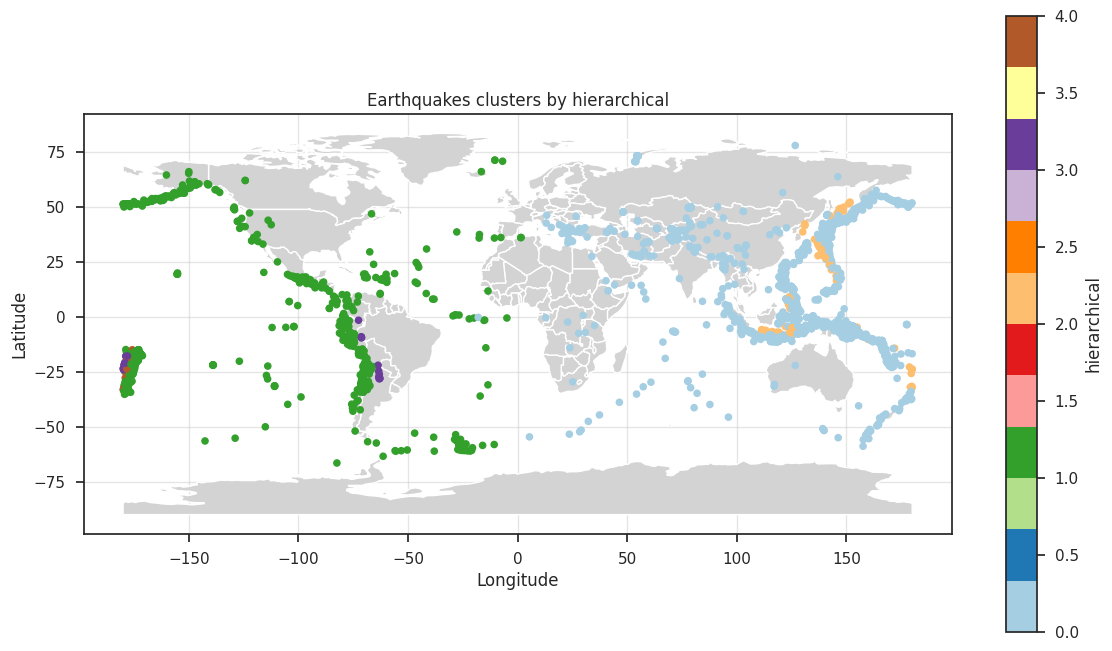

In [ ]:
showWorldMap('hierarchical')

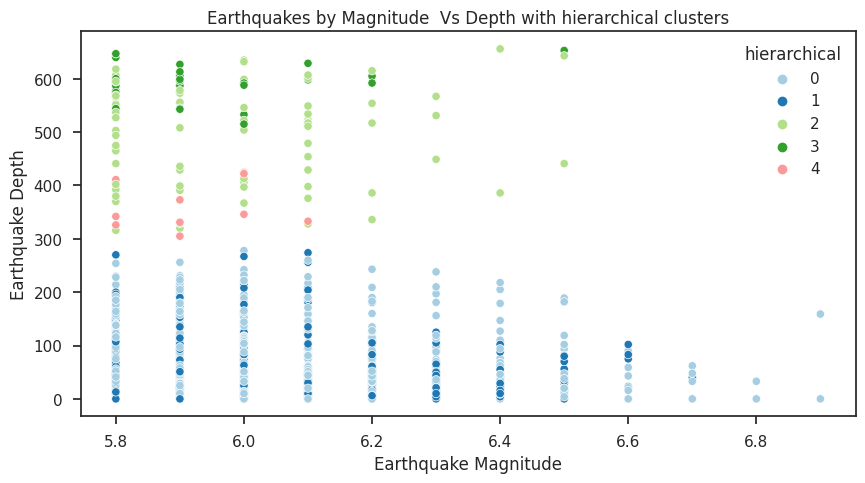

In [ ]:
plotScatterplot('hierarchical')

## Use labelled and unlabeled metrics to estimate quality of clusters you built. As ground truth use cluster labels from K-Means, choose most similar algorithm (20%)

In [ ]:
models = ['kmeans', 'DBSCAN', 'hierarchical']

metrics = pd.DataFrame()
for m in models:
  dict = {}

  arands = adjusted_rand_score(df['kmeans'], df[m])
  amif = adjusted_mutual_info_score(df['kmeans'], df[m])
  chs = calinski_harabasz_score(x, df[m])
  sils = silhouette_score(x, df[m])

  dict['AdjustedRandScore'] = arands
  dict['AdjustedMutualInfoScore'] = amif
  dict['CalinskiHarabasz'] = chs
  dict['SilhouetteScore'] = sils

  metrics[m] = dict

In [ ]:
metrics

,kmeans,DBSCAN,hierarchical
AdjustedRandScore,1.000000,0.336294,0.242603
AdjustedMutualInfoScore,1.000000,0.492235,0.372662
CalinskiHarabasz,924.852367,346.821332,292.424901
SilhouetteScore,0.366748,0.322128,0.241634


* According to the labelled metrics, DBSCAN shows better agreement with the ground truth (kmeans) than hierarchical clustering.

* Calinski-Harabasz score is the highest for kmeans, which suggests well-defined, dense clusters.

* We got the best Silhouette Score also for kmeans.



## Explain the final choice of best clusterizations: give interpretation of clusters (10%)

Based on the metrics, the best choice is kmeans clustering.

The clusters:


1.   **Class 0:** Earthquakes on the northern hemisphere, where the Pacific Plate meets other tectonic plates, with more shallow focal depth
2.   **Class 1:** Earthquakes around the South American Plate, usually struck in medium depth
3.   **Class 2:** Earthquakes on the southern hemisphere, where the Pacific Plate meets other tectonic plates, usually struck in medium depth
4.   **Class 3:** Earthquakes at the junction of the Eurasian, African and Indian plates, with shallowest focal depth
5.   **Class 4:** Earthquakes around the Pacific plate, struck in great focal depth, but smaller impact



## Visualize the best clusterizations in your opinion on the world map. (10%)

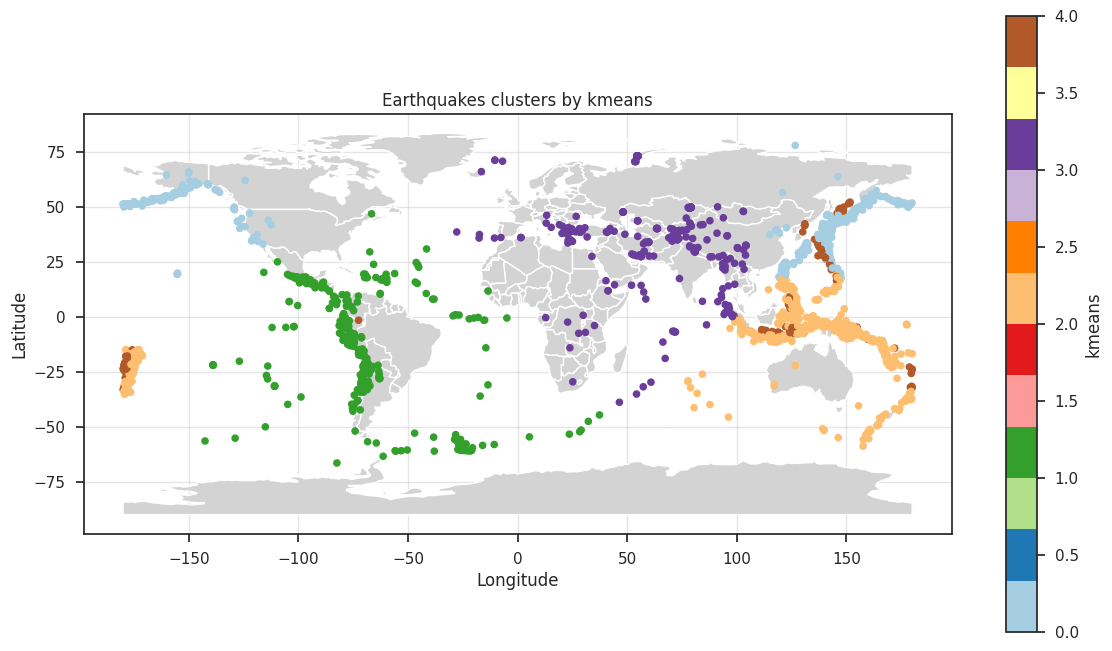

In [ ]:
showWorldMap('kmeans')